In [19]:
import os
import sys
import numpy as np
from scipy import stats
import sklearn.cluster as cluster
from collections import Counter
import umap
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from bayesmf.scripts.utils.dataset import make_downsampled_dataset
from bayesmf.models.bmf import BMF
from bayesmf.models.cmf import CMF

%reload_ext autoreload
%autoreload 2

In [32]:
DIR_PATH = '/home/sxchao/bayesmf/output'

In [3]:
X, sparsity, genes = make_downsampled_dataset(return_genes=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
factorizer = BMF(K=15, random_state=22690, init='nmf')
factorizer.fit(X)

W = factorizer.Et.T
H = factorizer.Eb.T
X_pred = np.matmul(W, H)

reducer = umap.UMAP()
embedding = reducer.fit_transform(W)

c = np.sqrt(np.sum(X_pred, axis=1))
cl = cluster.KMeans(n_clusters=10).fit_predict(W)

/home/sxchao/bayesmf/models/bmf.py:139: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)


In [17]:
sqerr = (X.T - X_pred)**2
y = np.sqrt(np.sum(sqerr, axis=1) / 100)

/home/sxchao/.conda/envs/snakes/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


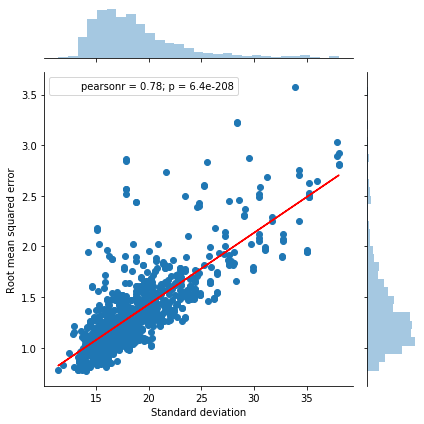

In [33]:
jp = sns.jointplot(x=c, y=y, stat_func=stats.pearsonr)
jp.set_axis_labels('Standard deviation', 'Root mean squared error')

linreg = stats.linregress(c, y)
jp.ax_joint.plot(c, linreg.intercept + linreg.slope * c, 'r')

plt.tight_layout()
plt.savefig(os.path.join(DIR_PATH, 'rmse_uncertainty_downsampled.png'), bbox_inches='tight', dpi=200)
plt.show()

In [38]:
d = Counter(cl)
i = sorted(d.items(), key = lambda x: x[1], reverse=True)[0][0]
idxs = np.nonzero(np.array(cl) == i)[0]

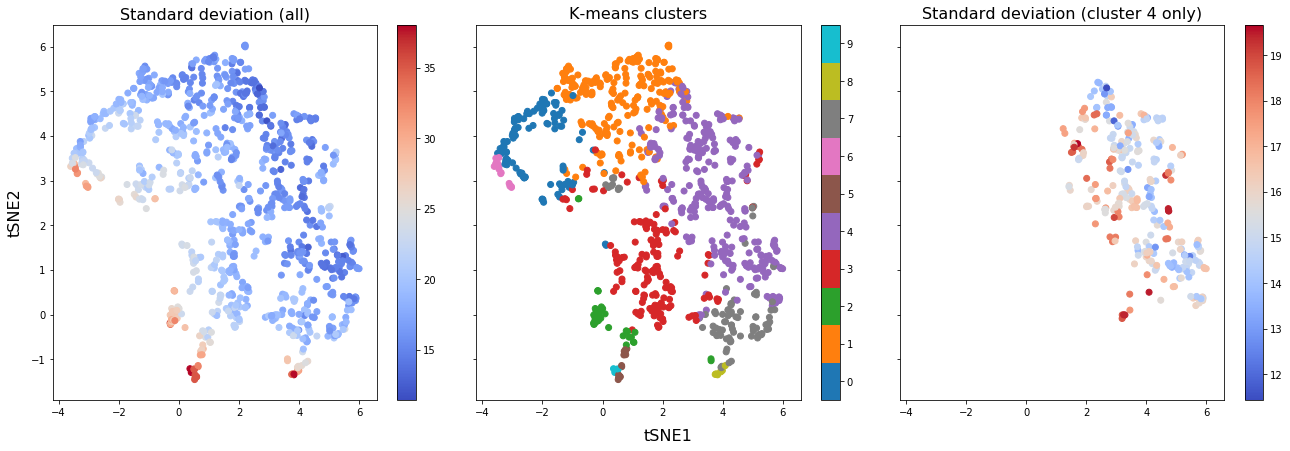

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

cmap=plt.cm.tab10
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5, 10.5, 1), cmap.N)

im0 = ax[0].scatter(x=embedding[:,0], y=embedding[:,1], c=c, cmap='coolwarm')
im1 = ax[1].scatter(x=embedding[:,0], y=embedding[:,1], c=np.array(cl), cmap='tab10', norm=norm)
im2 = ax[2].scatter(x=embedding[idxs,0], y=embedding[idxs,1], c=c[idxs], cmap='coolwarm')

cb0 = fig.colorbar(im0, ax=ax[0])
cb1 = fig.colorbar(im1, ax=ax[1], ticks=np.linspace(0,9,10))
cb2 = fig.colorbar(im2, ax=ax[2])

ax[0].set_title('Standard deviation (all)', fontsize=16)
ax[1].set_title('K-means clusters', fontsize=16)
ax[2].set_title('Standard deviation (cluster {} only)'.format(i), fontsize=16)

fig.text(0.5, -0.03, 'tSNE1', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'tSNE2', va='center', rotation='vertical', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(DIR_PATH, 'tsne_uncertainty_downsampled.png'), bbox_inches='tight', dpi=200)
plt.show()

In [20]:
cfactorizer = CMF(K=15, random_state=22690, init='nmf', verbose=True)
cfactorizer.fit(X)

/home/sxchao/bayesmf/models/cmf.py:135: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)


Iter: 0, Bound: 13616100.94, Change: nan
Iter: 1, Bound: 13995948.26, Change: 0.02790
Iter: 2, Bound: 13975636.74, Change: -0.00145


CMF(K=15, init='nmf', m=10, max_iters=100, num_steps=1, random_state=22690,
    smoothness=100, step_size=1e-05, tolerance=0.0005, verbose=True)

In [21]:
l = cfactorizer.l
a = l / np.linalg.norm(l, axis=1)[:, np.newaxis]
corr = np.matmul(a ,a.T)

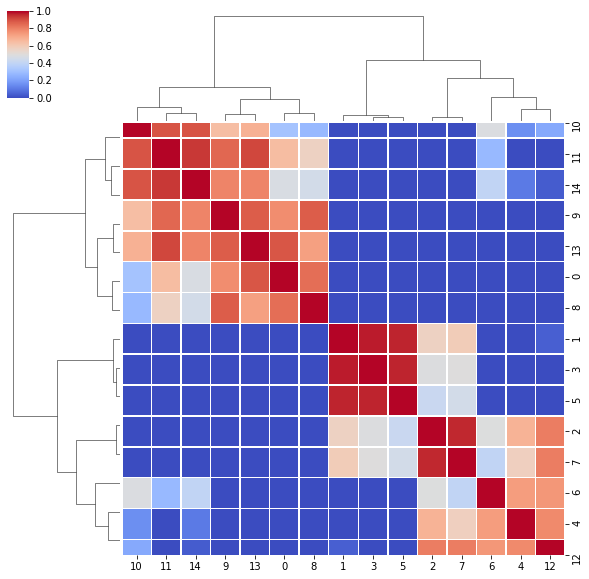

In [45]:
ax = sns.clustermap(corr, cmap='coolwarm', linewidths=.5, vmin=0, vmax=1)

plt.savefig(os.path.join(DIR_PATH, 'corr_heatmap_downsampled.png'), bbox_inches='tight', dpi=200)
plt.show()

In [24]:
W = np.exp(cfactorizer.alpha[np.newaxis, :] + np.dot(l, cfactorizer.u.T)).T
H = cfactorizer.Eb.T

In [27]:
idxs = np.argsort(np.sum(W, axis=0))[::-1]

for k in idxs:
    idxs = np.argsort(H[k, :])[::-1]
    print(k, genes[idxs[:10]].tolist())

0 ['GAPDH', 'RPS14', 'RPS3', 'RPS23', 'NEDD8', 'ATP5I', 'CD52', 'UBB', 'ACTR3', 'SUMO2']
1 ['RPS14', 'RPS3', 'RPS23', 'GAPDH', 'NEDD8', 'PNRC1', 'SPOCK2', 'SUMO2', 'ATP5I', 'NPM1']
13 ['GAPDH', 'ARL6IP1', 'SPOCK2', 'RPS14', 'RPS23', 'RPS3', 'CD3D', 'ACTR3', 'YBX1', 'CLIC1']
5 ['RPS3', 'RPS14', 'GAPDH', 'CD3D', 'RPS23', 'GPSM3', 'CD52', 'CLIC1', 'UBE2L6', 'ICAM3']
3 ['RPS23', 'RPS3', 'GAPDH', 'SUMO2', 'RPS14', 'COX6C', 'HMGN1', 'TMIGD2', 'IFITM1', 'PPP1R18']
8 ['NPM1', 'RPS23', 'RANBP1', 'SUMO2', 'ATP5O', 'NDUFB8', 'COX6C', 'RPS14', 'RPS3', 'NDUFA6']
9 ['YBX1', 'HMGN1', 'COX6C', 'GAPDH', 'CDK2AP2', 'RANBP1', 'RPS14', 'RPS3', 'EIF4G2', 'NEDD8']
14 ['HMGN1', 'SUMO2', 'GAPDH', 'ATP5I', 'CLIC1', 'ARL6IP1', 'ACTR3', 'PPP1R18', 'RPS14', 'RPS3']
11 ['GAPDH', 'CLIC1', 'UBB', 'SUMO2', 'COX6C', 'YBX1', 'ACTR3', 'ATP5I', 'ATP5O', 'PPP1R18']
12 ['RPS14', 'CD3D', 'GZMK', 'SUMO2', 'RPS3', 'CLIC1', 'GAPDH', 'NDUFB8', 'IFITM1', 'ATP5I']
10 ['UBB', 'ARL6IP1', 'HMGN1', 'COX6C', 'GAPDH', 'PRDX6', 'RPS3', 